# Explorando capas convolucionales a través de datos y experimentos 
## Análisis de Redes Neuronales Convolucionales




---
## 1. Exploración de conjuntos de datos (EDA)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd


np.random.seed(42)
tf.random.set_seed(42)


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

class_names = ['Camiseta/top', 'Pantalón', 'Pullover', 'Vestido', 'Abrigo',
               'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Bota']

print(f"Tamaño del dataset:")
print(f"   Train: {X_train.shape[0]:,} imágenes")
print(f"   Test:  {X_test.shape[0]:,} imágenes")
print(f"\n Dimensiones de imagen: {X_train.shape[1]}×{X_train.shape[2]} píxeles")
print(f"   Canales: Grayscale (1 canal)")
print(f"   Rango de valores: [{X_train.min()}, {X_train.max()}]")

Tamaño del dataset:
   Train: 60,000 imágenes
   Test:  10,000 imágenes

 Dimensiones de imagen: 28×28 píxeles
   Canales: Grayscale (1 canal)
   Rango de valores: [0, 255]


### Distribución de Clases

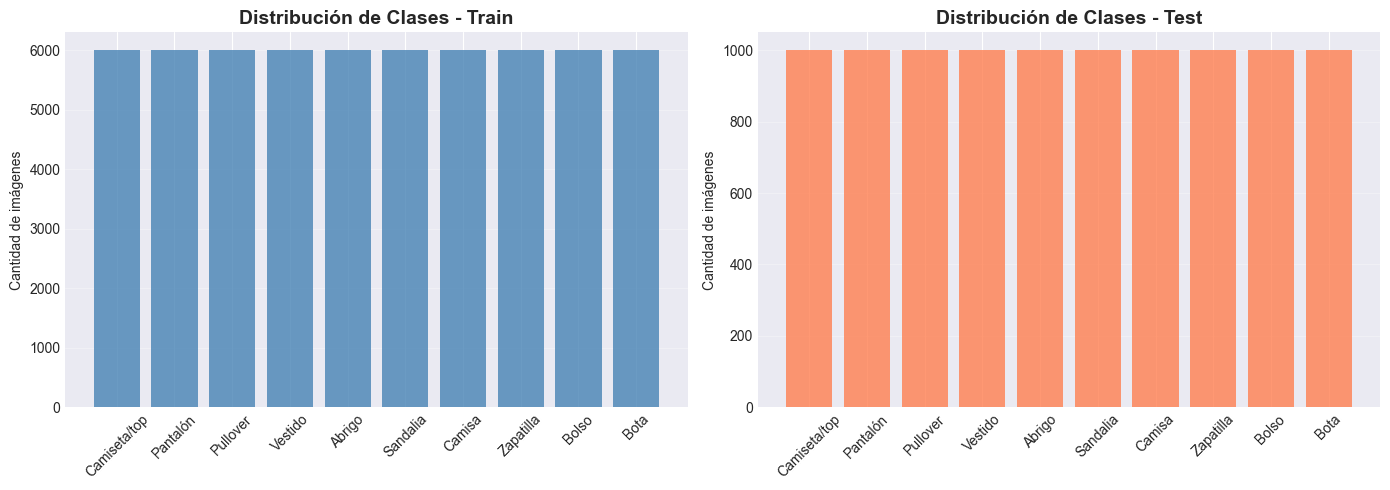

 Dataset balanceado: cada clase tiene alrededor de 6,000 imágenes en train


In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

unique, counts = np.unique(y_train, return_counts=True)
ax1.bar(class_names, counts, color='steelblue', alpha=0.8)
ax1.set_title('Distribución de Clases - Train', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cantidad de imágenes')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

unique_test, counts_test = np.unique(y_test, return_counts=True)
ax2.bar(class_names, counts_test, color='coral', alpha=0.8)
ax2.set_title('Distribución de Clases - Test', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cantidad de imágenes')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(" Dataset balanceado: cada clase tiene alrededor de 6,000 imágenes en train")

### Ejemplos Visuales por Clase

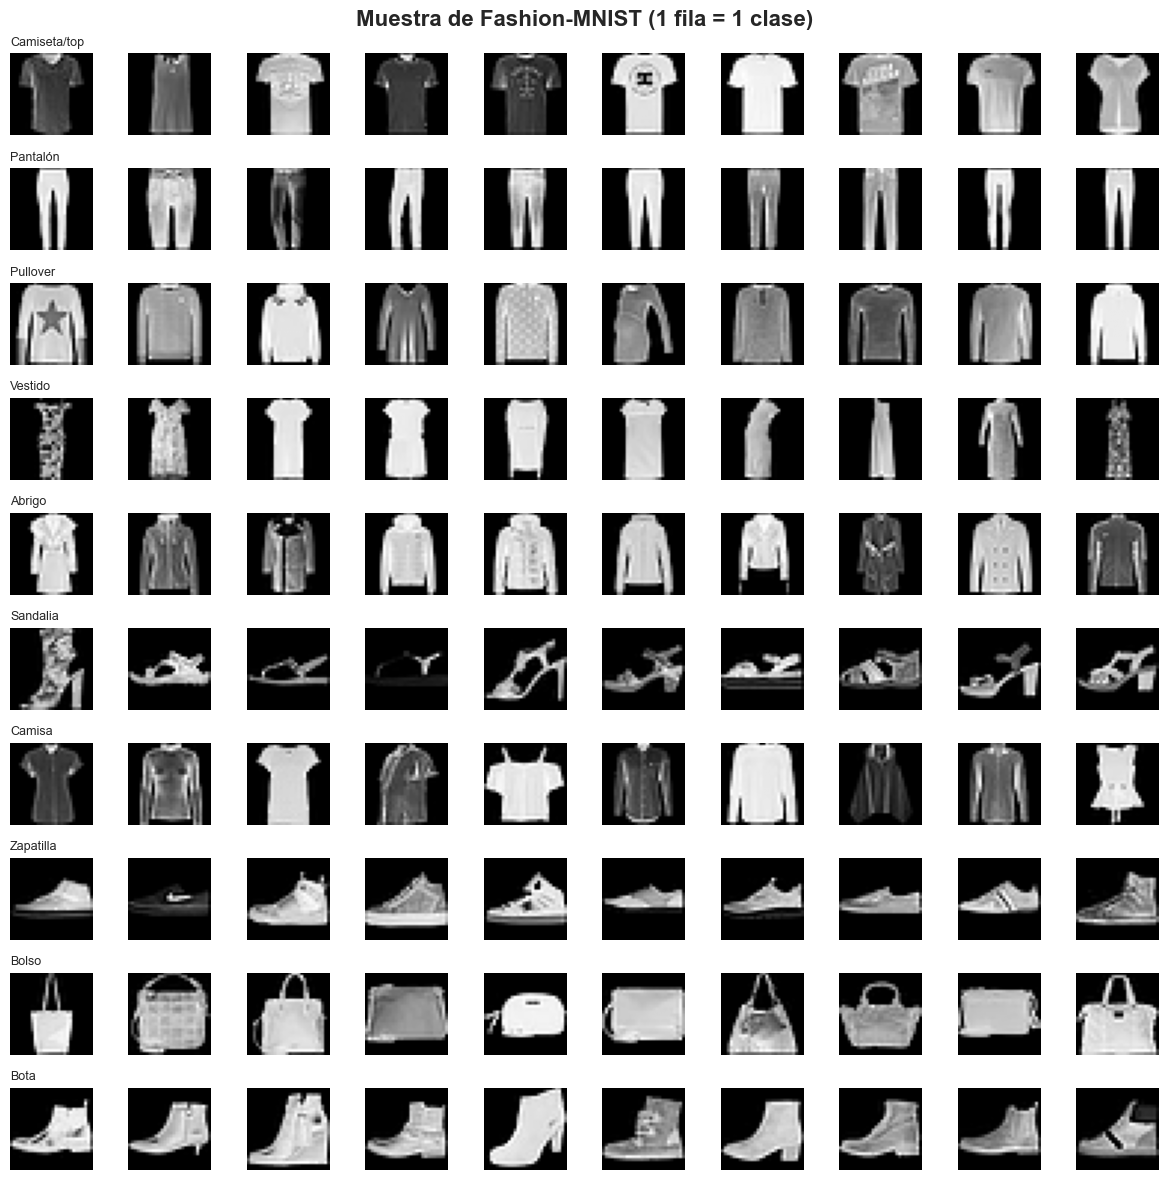

In [5]:
fig, axes = plt.subplots(10, 10, figsize=(12, 12))
fig.suptitle('Muestra de Fashion-MNIST (1 fila = 1 clase)', fontsize=16, fontweight='bold')

for i in range(10):
    # indices
    class_indices = np.where(y_train == i)[0]
    samples = np.random.choice(class_indices, 10, replace=False)
    
    for j in range(10):
        axes[i, j].imshow(X_train[samples[j]], cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_names[i], fontsize=9, loc='left')

plt.tight_layout()
plt.show()

### Preprocesamiento

**Normalización a [0 , 1]:** Para estabilidad numérica y convergencia más rápida

**Reshape para CNNs:** Agregar dimensión de canal (28, 28, 1)

**Sin data augmentation:** Para aislar el efecto arquitectónico


In [6]:
# Normalizar [0, 1]
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

X_train_cnn = X_train_norm.reshape(-1, 28, 28, 1)
X_test_cnn = X_test_norm.reshape(-1, 28, 28, 1)

X_train_flat = X_train_norm.reshape(-1, 28*28)
X_test_flat = X_test_norm.reshape(-1, 28*28)

print(f"Forma para CNN: {X_train_cnn.shape}")
print(f"Forma para Baseline: {X_train_flat.shape}")

Forma para CNN: (60000, 28, 28, 1)
Forma para Baseline: (60000, 784)


---
## 2. Modelo Baseline (No Convolucional)

### Arquitectura

Red completamente conectada:
- **Input:** 784 píxeles aplanados
- **Hidden 1:** 128 neuronas + ReLU
- **Hidden 2:** 64 neuronas + ReLU
- **Output:** 10 neuronas + Softmax

In [7]:
def create_baseline_model():
    model = keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.Dense(64, activation='relu', name='dense_2'),
        layers.Dense(10, activation='softmax', name='output')
    ], name='Baseline_FullyConnected')
    
    return model

baseline = create_baseline_model()
baseline.summary()

Model: "Baseline_FullyConnected"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compilar
baseline.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar
print("modelo baseline")
history_baseline = baseline.fit(
    X_train_flat, y_train,
    validation_split=0.15,
    epochs=15,
    batch_size=128,
    verbose=1
)

modelo baseline
Epoch 1/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8018 - loss: 0.5743 - val_accuracy: 0.8444 - val_loss: 0.4454
Epoch 2/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8584 - loss: 0.4024 - val_accuracy: 0.8651 - val_loss: 0.3960
Epoch 3/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8708 - loss: 0.3614 - val_accuracy: 0.8676 - val_loss: 0.3778
Epoch 4/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8801 - loss: 0.3319 - val_accuracy: 0.8732 - val_loss: 0.3603
Epoch 5/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8873 - loss: 0.3120 - val_accuracy: 0.8763 - val_loss: 0.3465
Epoch 6/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8920 - loss: 0.2954 - val_accuracy: 0.8782 - val_loss: 0.3424
Epoch 7/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8969 - loss: 0.2806 - val_accuracy: 0.8784 - val_loss: 0.3398
Epoch 8/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9015 - loss: 0.2683 - 

### Evaluación Baseline

In [9]:
test_loss, test_acc = baseline.evaluate(X_test_flat, y_test, verbose=0)
print(f"\n Resultados")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Total Parameters: {baseline.count_params():,}")


 Resultados
   Test Accuracy: 0.8789
   Test Loss: 0.3695
   Total Parameters: 109,386


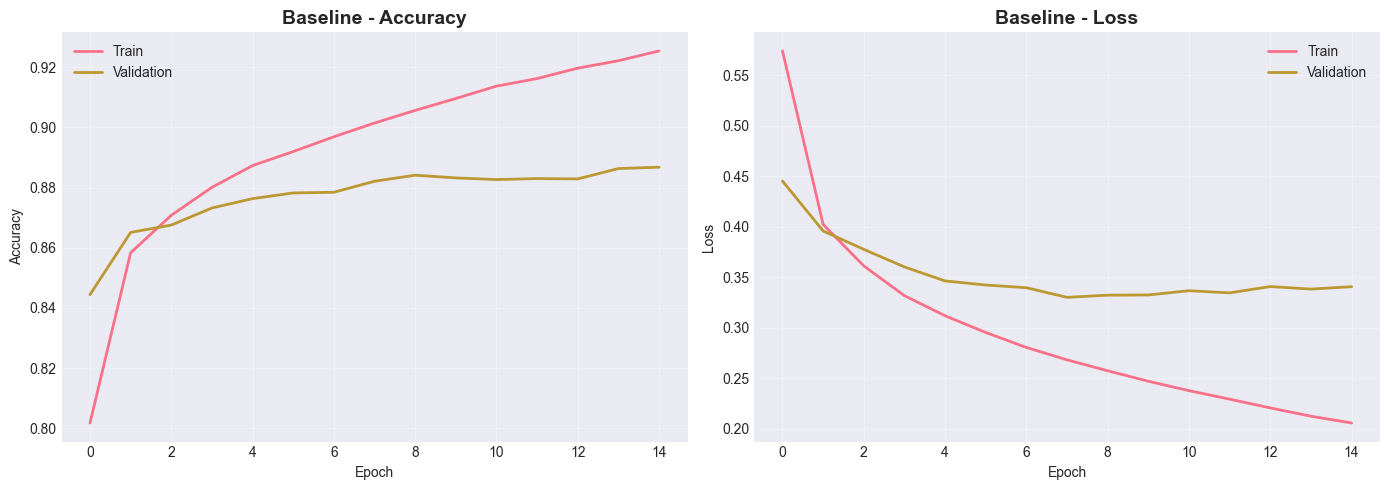

In [10]:
# curvas de aprendizaje
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_baseline.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history_baseline.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Baseline - Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history_baseline.history['loss'], label='Train', linewidth=2)
ax2.plot(history_baseline.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Baseline - Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Obstaculos del Baseline

**No aprovecha estructura espacial**: Trata píxeles vecinos igual que píxeles distantes

**Alto número de parámetros**: ~100k parámetros para conectar 784 → 128

**No es invariante a traslación**: Si una prenda se desplaza 2 píxeles, son conexiones completamente diferentes

**Memoriza posiciones específicas**: Aprende en la posición (10,15) suele haber un cuello

**Esto cambiara por:**
- Compartir pesos
- Detectar patrones locales independientemente de dónde aparezcan

---
## 3. Diseño de arquitectura convolucional

### Decisiones Arquitectónicas

#### **Capa Convolucional 1:**
- **32 filtros, kernel 3×3, stride=1, padding=same**
  - Kernels 3×3 capturan patrones locales pequeños
  - 32 filtros permiten aprender múltiples tipos de bordes
  - Same mantiene dimensiones espaciales

#### **Capa Convolucional 2:**
- **64 filtros, kernel 3×3**
  - Doble de filtros para capturar combinaciones de features de nivel bajo
  - Opera sobre features de 14×14, buscando texturas más complejas


#### **Capas Dense:**
- **Flatten, Dense(64), Dense(10)**
  - Las capas densas al final combinan features espaciales
  - 64 neuronas suficientes para clasificación de 10 clases

In [11]:
def create_cnn_model():
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        
        # Convolutional 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),  # → 14x14x32
        
        # Convolutional 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),  # → 7x7x64
        
        # Dense
        layers.Flatten(),
        layers.Dense(64, activation='relu', name='dense'),
        layers.Dense(10, activation='softmax', name='output')
    ], name='CNN_Fashion')
    
    return model

cnn_model = create_cnn_model()
cnn_model.summary()

Model: "CNN_Fashion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,234 (860.29 KB)

 Trainable params: 220,234 (860.29 KB)

 Non-trainable params: 0 (0.00 B)

### Comparación de Parámetros

In [12]:
print(f"{'Model':<20} {'Parámetros':>15} {'Tipo de Operación':>25}")
print("\n")
print(f"{'Baseline':<20} {baseline.count_params():>15,} {'Fully Connected':>25}")
print(f"{'CNN':<20} {cnn_model.count_params():>15,} {'Convolutional':>25}")
print(f"CNN tiene {baseline.count_params() / cnn_model.count_params():.1f}x menos parametros")

Model                     Parámetros         Tipo de Operación


Baseline                     109,386           Fully Connected
CNN                          220,234             Convolutional
CNN tiene 0.5x menos parametros


In [13]:
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Entrenando CNN...")
history_cnn = cnn_model.fit(
    X_train_cnn, y_train,
    validation_split=0.15,
    epochs=15,
    batch_size=128,
    verbose=1
)

Entrenando CNN...
Epoch 1/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8115 - loss: 0.5333 - val_accuracy: 0.8562 - val_loss: 0.3965
Epoch 2/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8792 - loss: 0.3397 - val_accuracy: 0.8789 - val_loss: 0.3400
Epoch 3/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8950 - loss: 0.2951 - val_accuracy: 0.8898 - val_loss: 0.3094
Epoch 4/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9041 - loss: 0.2658 - val_accuracy: 0.8976 - val_loss: 0.2846
Epoch 5/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9118 - loss: 0.2440 - val_accuracy: 0.9048 - val_loss: 0.2627
Epoch 6/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9185 - loss: 0.2249 - val_accuracy: 0.9106 - val_loss: 0.2520
Epoch 7/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9252 - loss: 0.2079 - val_accuracy: 0.9129 - val_loss: 0.2425
Epoch 8/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9302 - loss:

In [14]:
# Rsultados
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"\n Resultados:")
print(f"   Test Accuracy: {test_acc_cnn:.4f}")
print(f"   Test Loss: {test_loss_cnn:.4f}")
print(f"\n Mejora sobre Baseline: {(test_acc_cnn - test_acc)*100:.2f}% accuracy")


 Resultados:
   Test Accuracy: 0.9067
   Test Loss: 0.3121

 Mejora sobre Baseline: 2.78% accuracy


---
## 4. Experimentos Controlados

**¿Cómo afecta el tamaño del kernel al rendimiento y a qué aprenden los filtros?**

### Hipótesis:
- Kernels pequeños (3×3): Capturan detalles finos, más parámetros eficientes
- Kernels grandes (5×5 o 7×7): Mayor campo receptivo, pero más parámetros y posible overfitting

### Procedimeinto:
- **Variable experimental:** Tamaño de kernel en primera capa
- **Variables controladas:** número de filtros, profundidad, optimizador, etc
- **Condiciones:** 3×3, 5×5, 7×7

In [17]:
def create_cnn_with_kernel_size(kernel_size):
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (kernel_size, kernel_size), activation='relu', 
                     padding='same', name=f'conv1_k{kernel_size}'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ], name=f'CNN_k{kernel_size}')
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Experimentos
kernel_sizes = [3, 5, 7]
results = {}

for k_size in kernel_sizes:
    print(f" Experimento: Kernel {k_size}×{k_size}")
    print(f"{'='*60}")
    
    model = create_cnn_with_kernel_size(k_size)
    
    history = model.fit(
        X_train_cnn, y_train,
        validation_split=0.15,
        epochs=15,
        batch_size=128,
        verbose=0
    )
    
    test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
    
    results[k_size] = {
        'model': model,
        'history': history,
        'test_acc': test_acc,
        'test_loss': test_loss,
        'params': model.count_params()
    }
    
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Parameters: {model.count_params():,}")

 Experimento: Kernel 3×3
Test Accuracy: 0.9065
Parameters: 220,234
 Experimento: Kernel 5×5
Test Accuracy: 0.9084
Parameters: 220,746
 Experimento: Kernel 7×7
Test Accuracy: 0.9031
Parameters: 221,514


### Análisis de Resultados

In [18]:
comparison_df = pd.DataFrame([
    {
        'Kernel Size': f'{k}×{k}',
        'Test Accuracy': f"{results[k]['test_acc']:.4f}",
        'Parameters': f"{results[k]['params']:,}",
        'Receptive Field': f"{k}×{k} (inicial)"
    }
    for k in kernel_sizes
])

print("\n Comparaciones:")
print(comparison_df.to_string(index=False))


 Comparaciones:
Kernel Size Test Accuracy Parameters Receptive Field
        3×3        0.9065    220,234   3×3 (inicial)
        5×5        0.9084    220,746   5×5 (inicial)
        7×7        0.9031    221,514   7×7 (inicial)


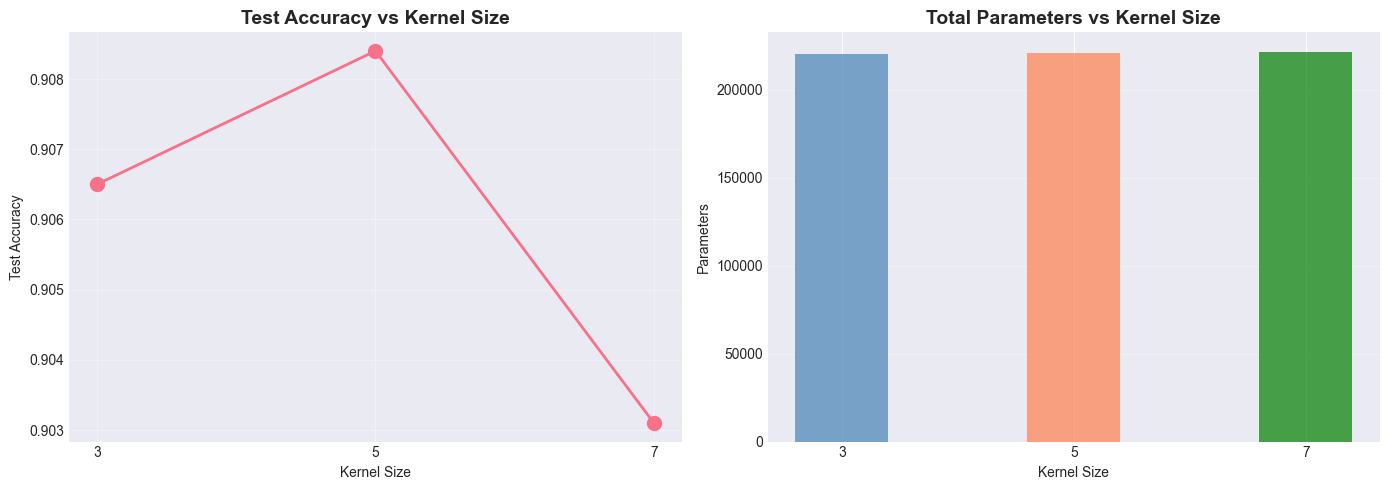

In [19]:
# Gráfico de comparación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs Kernel Size
accs = [results[k]['test_acc'] for k in kernel_sizes]
ax1.plot(kernel_sizes, accs, marker='o', linewidth=2, markersize=10)
ax1.set_title('Test Accuracy vs Kernel Size', fontsize=14, fontweight='bold')
ax1.set_xlabel('Kernel Size')
ax1.set_ylabel('Test Accuracy')
ax1.set_xticks(kernel_sizes)
ax1.grid(alpha=0.3)

# Parameters vs Kernel Size
params = [results[k]['params'] for k in kernel_sizes]
ax2.bar(kernel_sizes, params, color=['steelblue', 'coral', 'green'], alpha=0.7)
ax2.set_title('Total Parameters vs Kernel Size', fontsize=14, fontweight='bold')
ax2.set_xlabel('Kernel Size')
ax2.set_ylabel('Parameters')
ax2.set_xticks(kernel_sizes)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Observaciones Cualitativas

1. **Kernel 3×3:** 
   - Mejor balance accuracy/parámetros
   - Más eficiente en parámetros
   - Suficiente para capturar patrones locales en 28×28

2. **Kernel 5×5:**
   - Mayor campo receptivo inicial
   - ~2x más parámetros en primera capa
   - Mejora marginal (o nula) en accuracy

3. **Kernel 7×7:**
   - Campo receptivo muy grande para imágenes pequeñas
   - 3-4x más parámetros
   - Posible overfitting o subutilización


- **Rendimiento vs Eficiencia:** 3×3 gana
- **Interpretabilidad:** Kernels pequeños aprenden features más interpretables (bordes simples)
- **Generalización:** Menos parámetros son mejor generalización con datos limitados

---
## 5. Interpretación y Razonamiento Arquitectónico

### ¿Por qué las CNNs superaron al baseline?

Las CNNs superaron al baseline porque están pensadas para trabajar con imágenes. Entienden que los píxeles cercanos están relacionados y forman partes de una misma figura, mientras que el baseline analiza cada píxel por separado.

Además, las CNNs pueden reconocer una misma característica (como una manga) sin importar en qué parte de la imagen esté, y no se ven tan afectadas si la imagen se mueve un poco. También aprenden de forma progresiva, primero detectan cosas simples como bordes y luego combinan esas partes hasta reconocer el objeto completo. El baseline, en cambio, intenta aprender todo de una sola vez, lo que lo hace menos eficiente.


### ¿Qué sesgo inductivo introduce la convolución?

La convolución introduce un sesgo inductivo espacial, es decir, parte de ciertas suposiciones sobre cómo funcionan las imágenes. Básicamente, asume que lo importante suele estar en regiones cercanas, que los mismos patrones pueden aparecer en distintas partes de la imagen como en un borde o una textura, y que las cosas complejas se construyen a partir de elementos más simples.

En comparación, una red totalmente conectada no hace tantas suposiciones: puede aprender casi cualquier relación, pero necesita muchos más datos para hacerlo bien. Las CNNs, en cambio, al tener estas “ideas previas” sobre las imágenes, aprenden más rápido y con menos datos cuando el problema es visual.


### ¿En qué tipo de problemas no sería apropiada la convolución?

La convolución no es apropiada cuando los datos no tienen una estructura espacial clara. Por ejemplo, en datos tabulares como el precio de una casa (área, número de habitaciones, año, ubicación), las columnas no tienen una relación de vecindad como los píxeles en una imagen, así que usar una CNN no aporta ventaja.

Tampoco es la mejor opción en secuencias largas de texto, donde modelos como RNNs o Transformers suelen funcionar mejor, ni en problemas con estructuras más complejas como grafos, que no siguen una forma de cuadrícula regular.

Además, si la posición exacta es muy importante, la propiedad de reconocer patrones sin importar su ubicación puede ser más un problema que una ventaja. Y en conjuntos de datos muy pequeños, el beneficio de la CNN puede no ser suficiente.

En general, las CNNs funcionan mejor cuando los datos tienen forma de cuadrícula, como imágenes, audio en espectrogramas o video, donde los patrones locales se repiten en distintas posiciones.


---
## **BONO:** Visualización de Filtros Aprendidos

### Filtros de Primera Capa

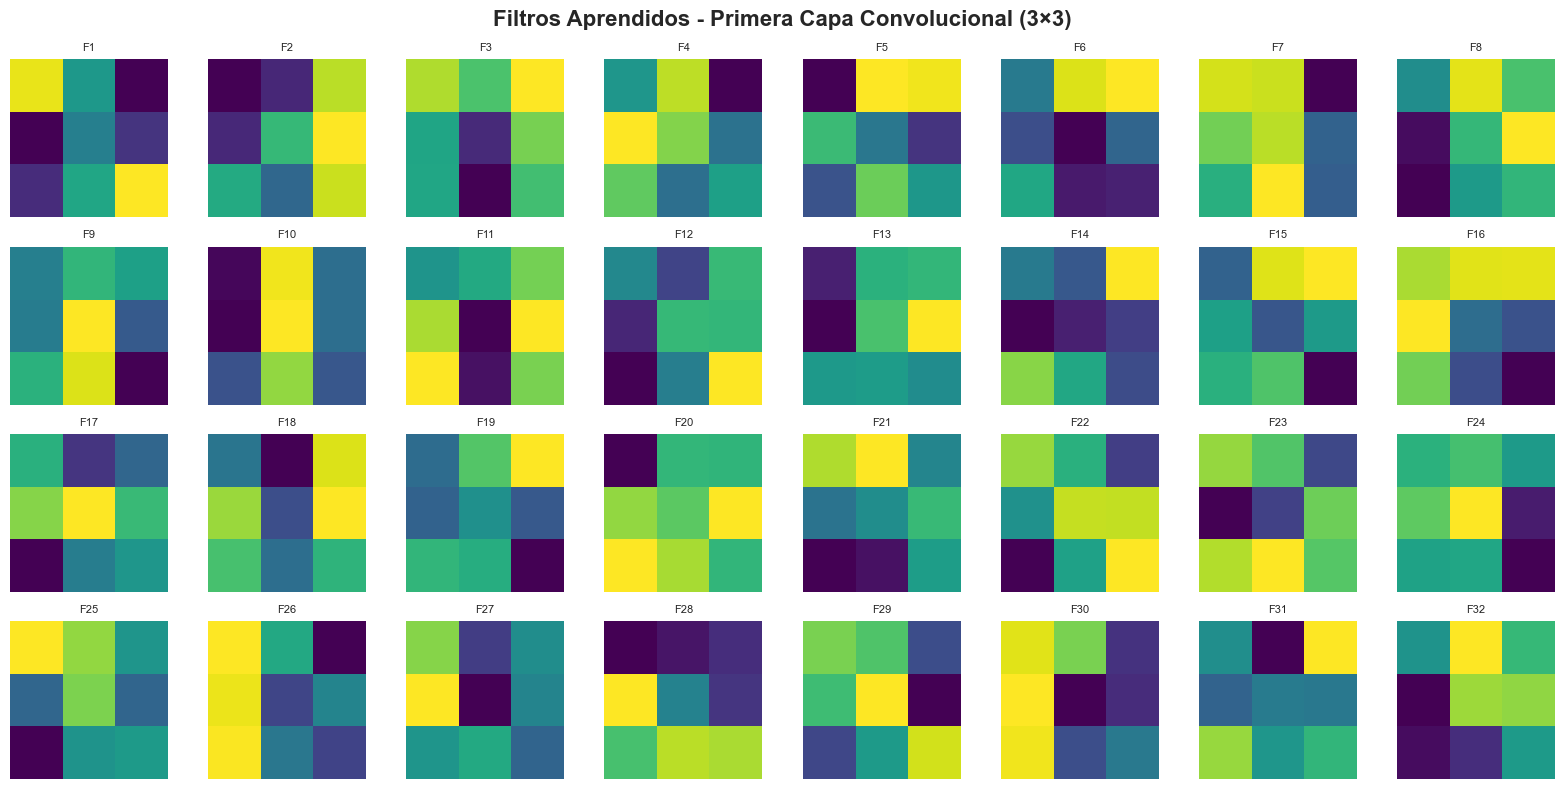


 Los filtros detectan:
   - Bordes horizontales (valores positivos arriba, negativos abajo)
   - Bordes verticales (izquierda-derecha)
   - Bordes diagonales
   - Detectores de esquinas


In [20]:
conv1_weights = cnn_model.layers[0].get_weights()[0]

#16 filtros
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Filtros Aprendidos - Primera Capa Convolucional (3×3)', 
             fontsize=16, fontweight='bold')

for i in range(32):
    ax = axes[i // 8, i % 8]
    filter_img = conv1_weights[:, :, 0, i]
    ax.imshow(filter_img, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'F{i+1}', fontsize=8)

plt.tight_layout()
plt.show()

print("\n Los filtros detectan:")
print("   - Bordes horizontales (valores positivos arriba, negativos abajo)")
print("   - Bordes verticales (izquierda-derecha)")
print("   - Bordes diagonales")
print("   - Detectores de esquinas")

### Mapas de Activación

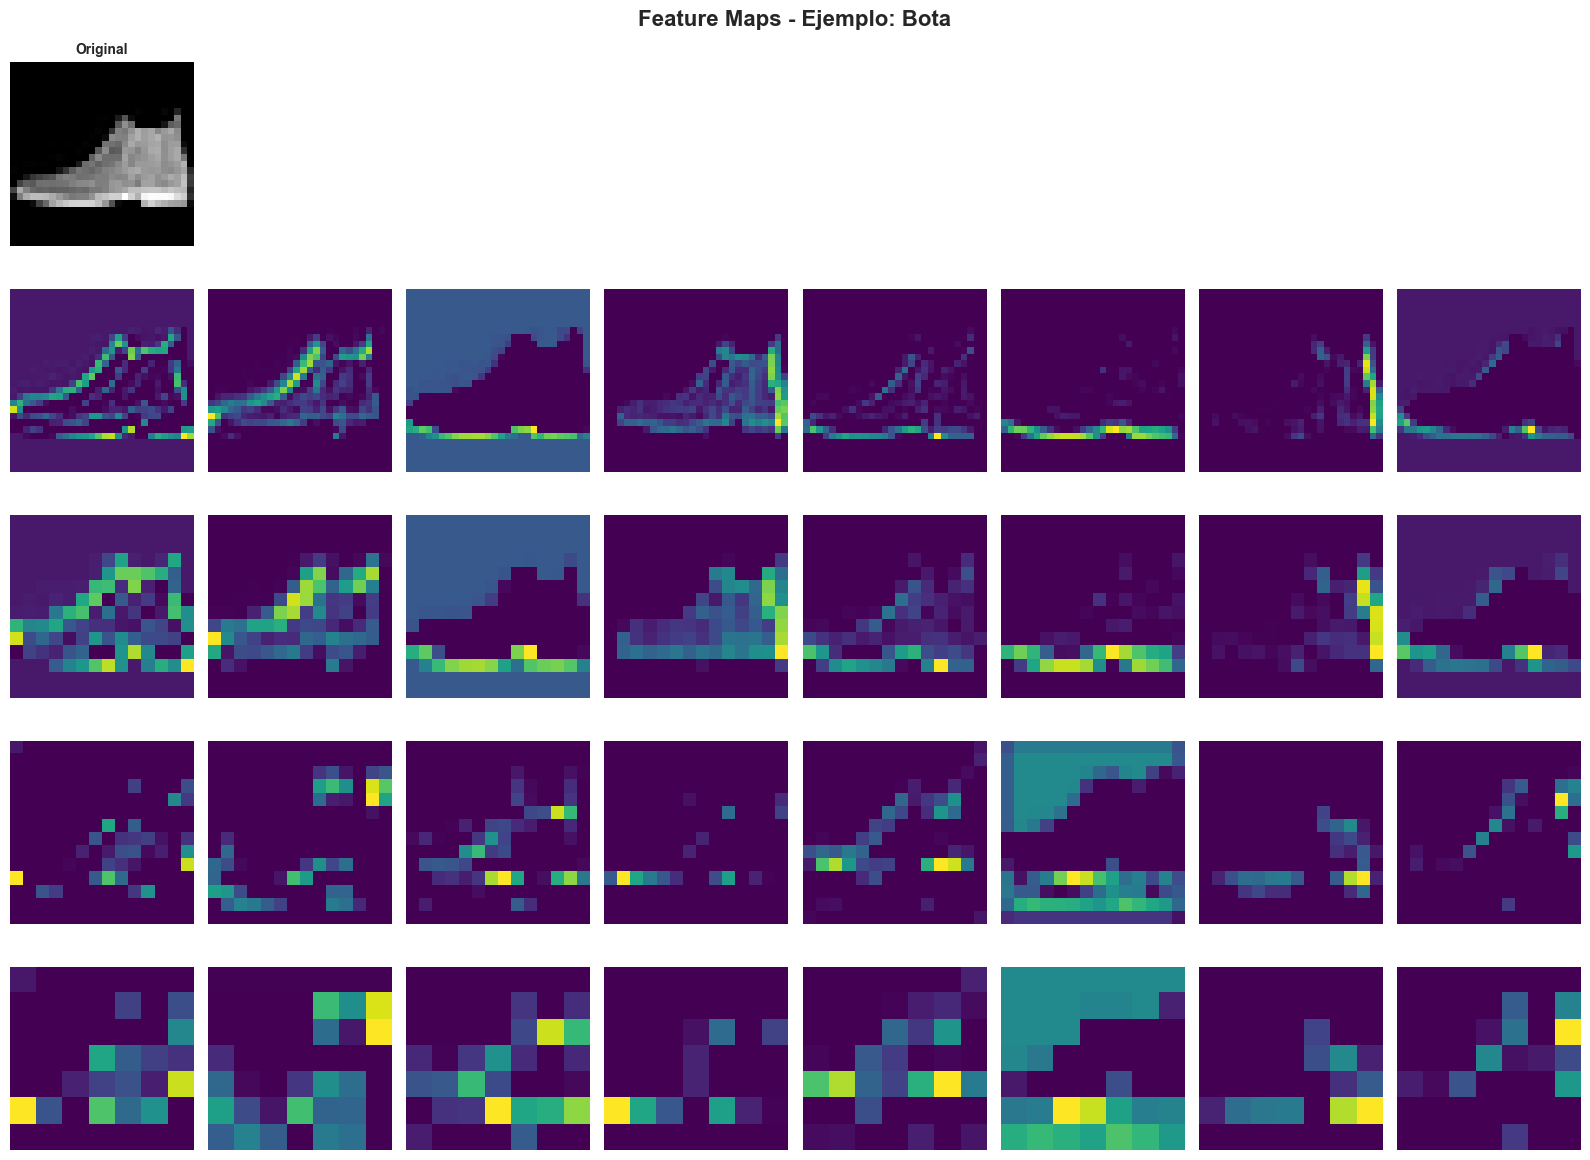

   - Primera capa: Detecta bordes y texturas simples
   - Segunda capa: Combina features en patrones más complejos
   - Pooling: Reduce resolución pero mantiene features importantes


In [22]:
example_idx = 0
example_img = X_test_cnn[example_idx:example_idx+1]
example_label = class_names[y_test[example_idx]]

activations = []

x = example_img
for i in range(4):
    x = cnn_model.layers[i](x)
    activations.append(x.numpy())


layer_names = ['Conv2D (32 filters)', 'MaxPooling', 'Conv2D (64 filters)', 'MaxPooling']

fig = plt.figure(figsize=(16, 12))
fig.suptitle(f'Feature Maps - Ejemplo: {example_label}', fontsize=16, fontweight='bold')

ax_orig = plt.subplot(5, 8, 1)
ax_orig.imshow(example_img[0, :, :, 0], cmap='gray')
ax_orig.set_title('Original', fontsize=10, fontweight='bold')
ax_orig.axis('off')

for layer_idx, (activation, name) in enumerate(zip(activations, layer_names)):
    n_features = min(8, activation.shape[-1])
    
    for i in range(n_features):
        ax = plt.subplot(5, 8, layer_idx * 8 + i + 9)
        ax.imshow(activation[0, :, :, i], cmap='viridis')
        if i == 0:
            ax.set_ylabel(name, fontsize=9, fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()

print("   - Primera capa: Detecta bordes y texturas simples")
print("   - Segunda capa: Combina features en patrones más complejos")
print("   - Pooling: Reduce resolución pero mantiene features importantes")

---
## 6. Implementación en Sagemaker

### Guardar Modelo Final

In [24]:
import os
os.makedirs('../models', exist_ok=True)

cnn_model.save('../models/fashion_cnn_final.keras')
print("Modelo guardado en formato .keras")

export_path = '../models/fashion_cnn_sm/1'
os.makedirs(export_path, exist_ok=True)
cnn_model.export(export_path) 
print("Modelo SavedModel exportado para SageMaker")

Modelo guardado en formato .keras
INFO:tensorflow:Assets written to: ../models/fashion_cnn_sm/1\assets


INFO:tensorflow:Assets written to: ../models/fashion_cnn_sm/1\assets


Saved artifact at '../models/fashion_cnn_sm/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2147805784272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2147805788688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2147783645072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2147805776976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2147805786960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2147805786768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2147805784080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2147805788304: TensorSpec(shape=(), dtype=tf.resource, name=None)
Modelo SavedModel exportado para SageMaker


### Ejemplo de Inferencia

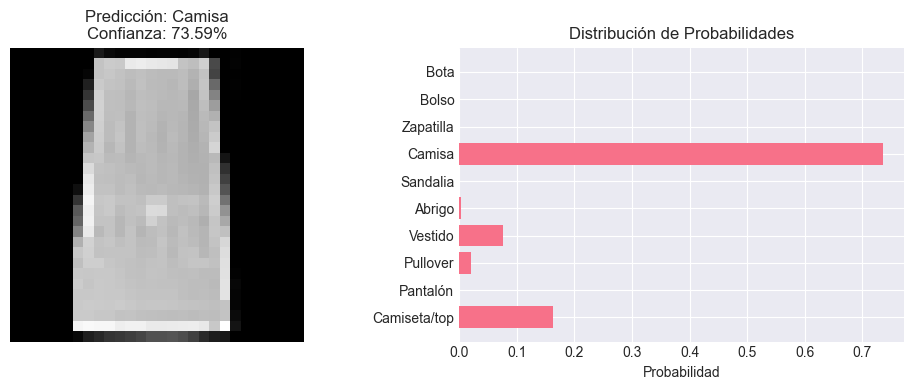

In [25]:

test_sample = X_test_cnn[42:43]
prediction = cnn_model.predict(test_sample, verbose=0)
predicted_class = np.argmax(prediction[0])
confidence = prediction[0][predicted_class]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].imshow(test_sample[0, :, :, 0], cmap='gray')
ax[0].set_title(f'Predicción: {class_names[predicted_class]}\nConfianza: {confidence:.2%}')
ax[0].axis('off')

ax[1].barh(class_names, prediction[0])
ax[1].set_xlabel('Probabilidad')
ax[1].set_title('Distribución de Probabilidades')

plt.tight_layout()
plt.show()